### Analyzing ordinal data with metric models: What could possibly go wrong?

Kruschke, J. K., & Liddell, T. (2018, April 5). Ordinal Data Analysis. Retrieved from http://osf.io/53ce9

PyMC3 implementation of the ordinal probit model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import Image
from theano.compile.ops import as_op
from scipy.stats import norm

%matplotlib inline

color = '#87ceeb'
f_dict = {'size':14}

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,theano,matplotlib,seaborn,scipy

pandas    : 1.5.3
numpy     : 1.22.1
pymc3     : 3.11.5
theano    : 1.1.2
matplotlib: 3.6.3
seaborn   : 0.12.2
scipy     : 1.7.3



Function `gammaShRaFromModeSD` ported from https://osf.io/eujgd/

In [3]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [4]:
data = pd.read_csv('https://osf.io/zftb3/download')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       36 non-null     int64 
 1   Descrip  36 non-null     object
 2   n1       36 non-null     int64 
 3   n2       36 non-null     int64 
 4   n3       36 non-null     int64 
 5   n4       36 non-null     int64 
 6   n5       36 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 2.1+ KB


In [5]:
data.head()

,ID,Descrip,n1,n2,n3,n4,n5
0,1,The Whole Truth,49,70,119,217,245
1,2,Priceless,67,22,22,60,574
2,3,Allied,59,76,102,203,406
3,4,The Infiltrator,173,216,518,1339,2073
4,5,Miss Sloane,180,60,48,120,793


In [6]:
# Columns n1 - n5
y = data.iloc[:,2:]

In [7]:
# Number of outcomes
nYlevels = y.columns.size
nYlevels

5

In [24]:
Ncases = y.index.size
Ncases

36

In [9]:
z = y.sum(1)
z.head()

0     700
1     745
2     846
3    4319
4    1201
dtype: int64

In [10]:
gammaShRa = gammaShRaFromModeSD(3,3)
gammaShRa

(2.618033988749895, 0.5393446629166316)

#### Lower panel of figure 1

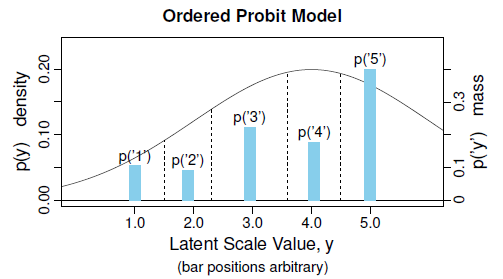

In [11]:
Image('Ordered_Probit_Model.png')

*A latent scale on the horizontal axis is divided into subintervals with thresholds marked by
dashed lines. The cumulative normal probability in the subintervals is the probability of the
ordinal values. The cumulative normal probability mass within each interval is indicated
by the height of the corresponding bar, with numerical scale indicated on the right vertical
axis.* 
(Kruschke & Liddell, 2018, April 5)

### Model - JAGS 
(Kruschke & Liddell, 2018, Version 3)  
https://osf.io/t53rk/

#### Note: model contains a hierarchical structure on the standard deviations across movies, but not on the means of the movies.

```
# THE *ORDERED PROBIT* MODEL:
  modelString = paste0("
  model {
    for ( i in 1:Ncases ) {
      y[i, ] ~ dmulti( pr[i,1:nYlevels] , z[i] )
      pr[i,1] <- pnorm( thresh[1] , mu[x[i]] , 1/sigma[x[i]]^2 )
      for ( k in 2:(nYlevels-1) ) {
        pr[i,k] <- max( 0 ,  pnorm( thresh[ k ] , mu[x[i]] , 1/sigma[x[i]]^2 )
                            - pnorm( thresh[k-1] , mu[x[i]] , 1/sigma[x[i]]^2 ) )
      }
      pr[i,nYlevels] <- 1 - pnorm( thresh[nYlevels-1] , mu[x[i]] , 1/sigma[x[i]]^2 )
    }
    for ( j in 1:Ncases ) { 
      mu[j] ~ dnorm( (1+nYlevels)/2 , 1/(nYlevels)^2 )
      sigma[j] ~ dgamma( sigmaSh , sigmaRa )
    }
    sigmaSh <- 1 + sigmaMode * sigmaRa
    sigmaRa <- ( ( sigmaMode + sqrt( sigmaMode^2 + 4*sigmaSD^2 ) ) 
                  / ( 2*sigmaSD^2 ) ) ",
    ifelse( hierarchSD ,
      "sigmaMode ~ dgamma( gammaShRa[1] , gammaShRa[2] ) 
       sigmaSD ~ dgamma( gammaShRa[1] , gammaShRa[2] ) " ,
      "sigmaMode <- 3.0
       sigmaSD <- 3.0" ) , " # open quote for next line
    for ( k in 2:(nYlevels-2) ) {  # 1 and nYlevels-1 are fixed, not stochastic
      thresh[k] ~ dnorm( k+0.5 , 1/2^2 )
    }
  }") # close quote for modelString paste
```

### Model - PyMC3

In [12]:
# Thresholds, masking the the inner two values. 
thresh = [k + .5 for k in range(1, nYlevels)]
thresh_obs = np.ma.asarray(thresh)
thresh_obs[1:-1] = np.ma.masked

print('thresh:\t\t{}'.format(thresh))
print('thresh_obs:\t{}'.format(thresh_obs))

thresh:		[1.5, 2.5, 3.5, 4.5]
thresh_obs:	[1.5 -- -- 4.5]


In [30]:
Ncases=9
print(y.values[:9, :].shape)
print(z[:9, None].shape)
print(np.empty((nYlevels, Ncases), dtype=np.float64).shape)

(9, 5)
(9, 1)
(5, 9)


In [31]:
@as_op(itypes=[tt.dvector, tt.dvector, tt.dvector], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((nYlevels, Ncases), dtype=np.float64)
    n = norm(loc=mu, scale=sigma)
    lbound = np.repeat(0, Ncases)
    
    # Thresholded cumulative normal probabilities.
    # Four thresholds (theta values) define the 5 outcome probabilities.
    out[0,:] = n.cdf(theta[0])        
    out[1,:] = np.max([lbound, n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[2,:] = np.max([lbound, n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[3,:] = np.max([lbound, n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[4,:] = 1 - n.cdf(theta[3])

    return out

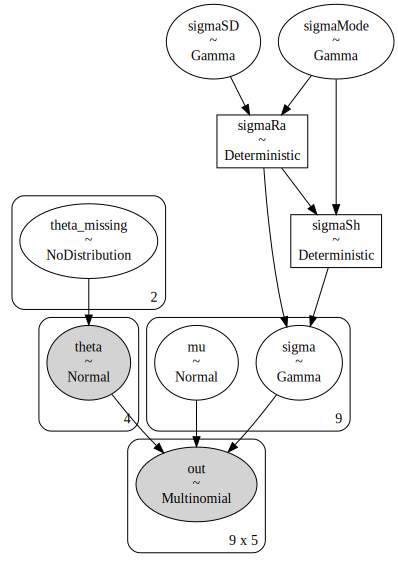

In [33]:
# Model a hierarchical sigma?
hierarchSD = True

with pm.Model() as ordinal_model_multi_groups:    
    # Latent means (rating) of the movies           
    mu = pm.Normal('mu', mu=(1+nYlevels)/2.0, tau=1.0/(nYlevels)**2, shape=Ncases)
    
    # Latent standard deviations of the ratings.
    if hierarchSD:
        sigmaSD = pm.Gamma('sigmaSD', gammaShRa[0], gammaShRa[1])
        sigmaMode = pm.Gamma('sigmaMode', gammaShRa[0], gammaShRa[1])
    else:
        sigmaSD = 3.0
        sigmaMode = 3.0
    sigmaRa = pm.Deterministic('sigmaRa', ((sigmaMode + pm.math.sqrt(sigmaMode**2 + 4*sigmaSD**2)) / (2*sigmaSD**2)))
    sigmaSh = pm.Deterministic('sigmaSh', 1 + sigmaMode*sigmaRa)
    sigma = pm.Gamma('sigma', sigmaSh, sigmaRa, shape=Ncases)
    
    # Latent thresholds between the ratings (ordinal values)
    theta = pm.Normal('theta', mu=thresh, tau=1/np.repeat(2**2, len(thresh)),
                      shape=len(thresh), observed=thresh_obs)
    
    # Cumulative normal probabilities for ratings (ordinal values)
    pr = outcome_probabilities(theta, mu, sigma)

    # Likelihood
    out = pm.Multinomial('out', n=z[:9, None], p=pr.T, observed=y.values[:9, :])
    
pm.model_to_graphviz(ordinal_model_multi_groups)

In [34]:
with ordinal_model_multi_groups:       
    trace = pm.sample(4000, cores=1, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [theta_missing]
>>Slice: [sigma]
>>Slice: [mu]
>NUTS: [sigmaMode, sigmaSD]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 1645 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/var/folders/_m/1bn8mz151gq93wdcqw8yx6jr0000gn/T/ipykernel_27902/3005609106.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, ['mu', 'sigmaSD', 'sigmaMode', 'sigma'], compact=True, combined=True);
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


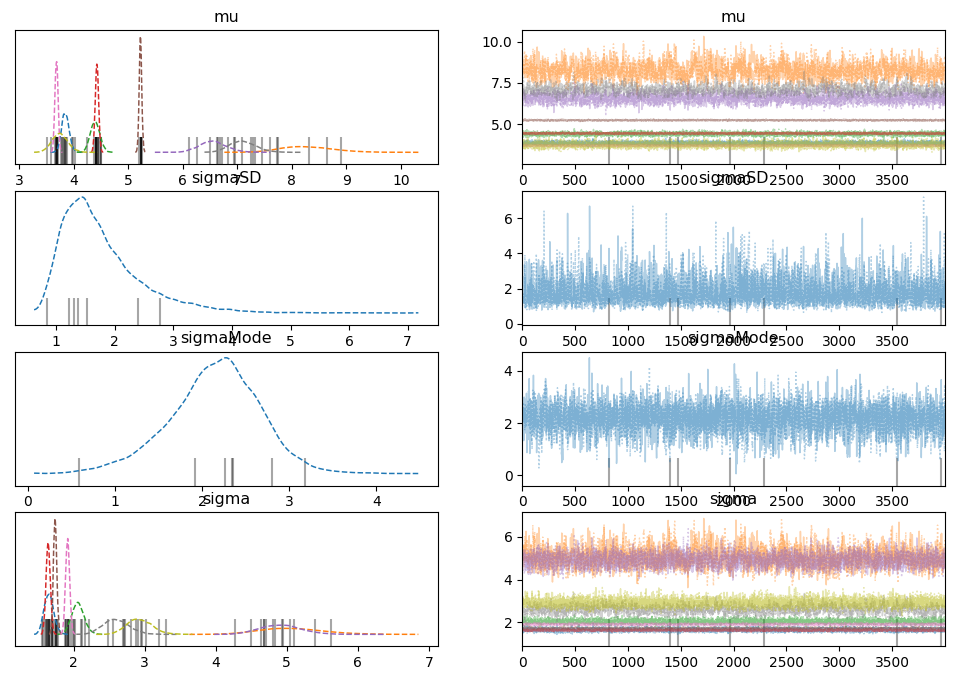

In [35]:
pm.traceplot(trace, ['mu', 'sigmaSD', 'sigmaMode', 'sigma'], compact=True, combined=True);

In [36]:
pm.summary(trace, ['theta_missing'])

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_missing[0],2.240,0.016,2.210,2.268,0.0,0.0,3194.0,5021.0,1.0
theta_missing[1],3.134,0.014,3.106,3.161,0.0,0.0,2912.0,4287.0,1.0


#### Kruschke, J. K., & Liddell, T.

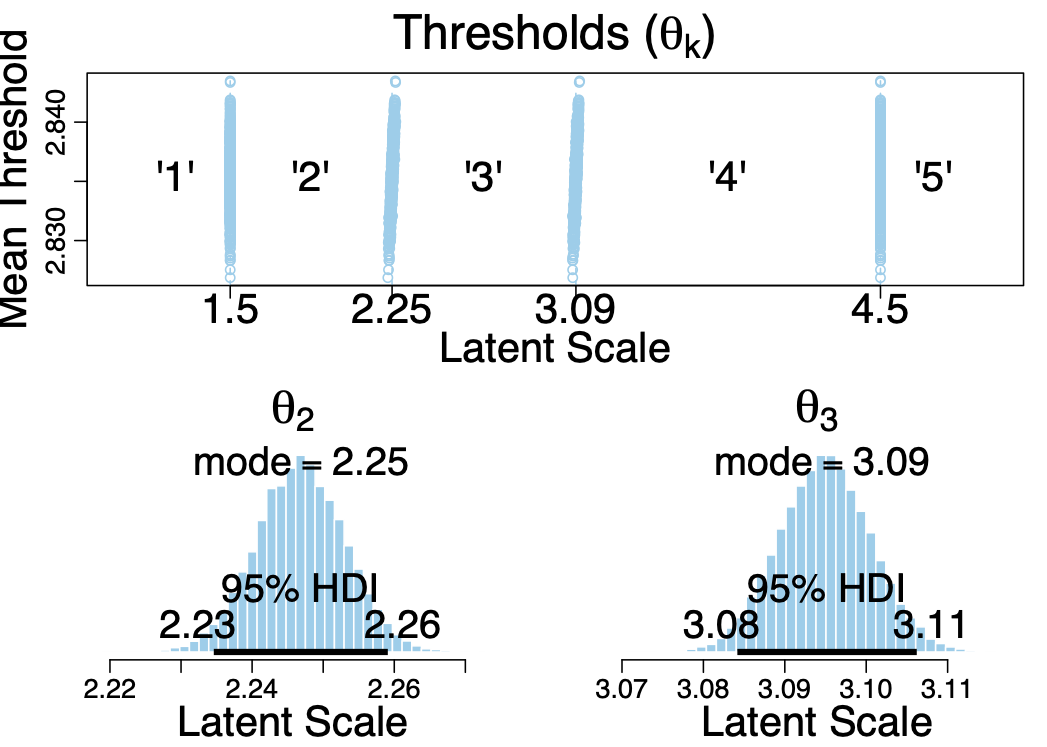

In [37]:
Image('images/OrderedProbitModel-MoviesData-OrdModel-Thresh.png', width=500)

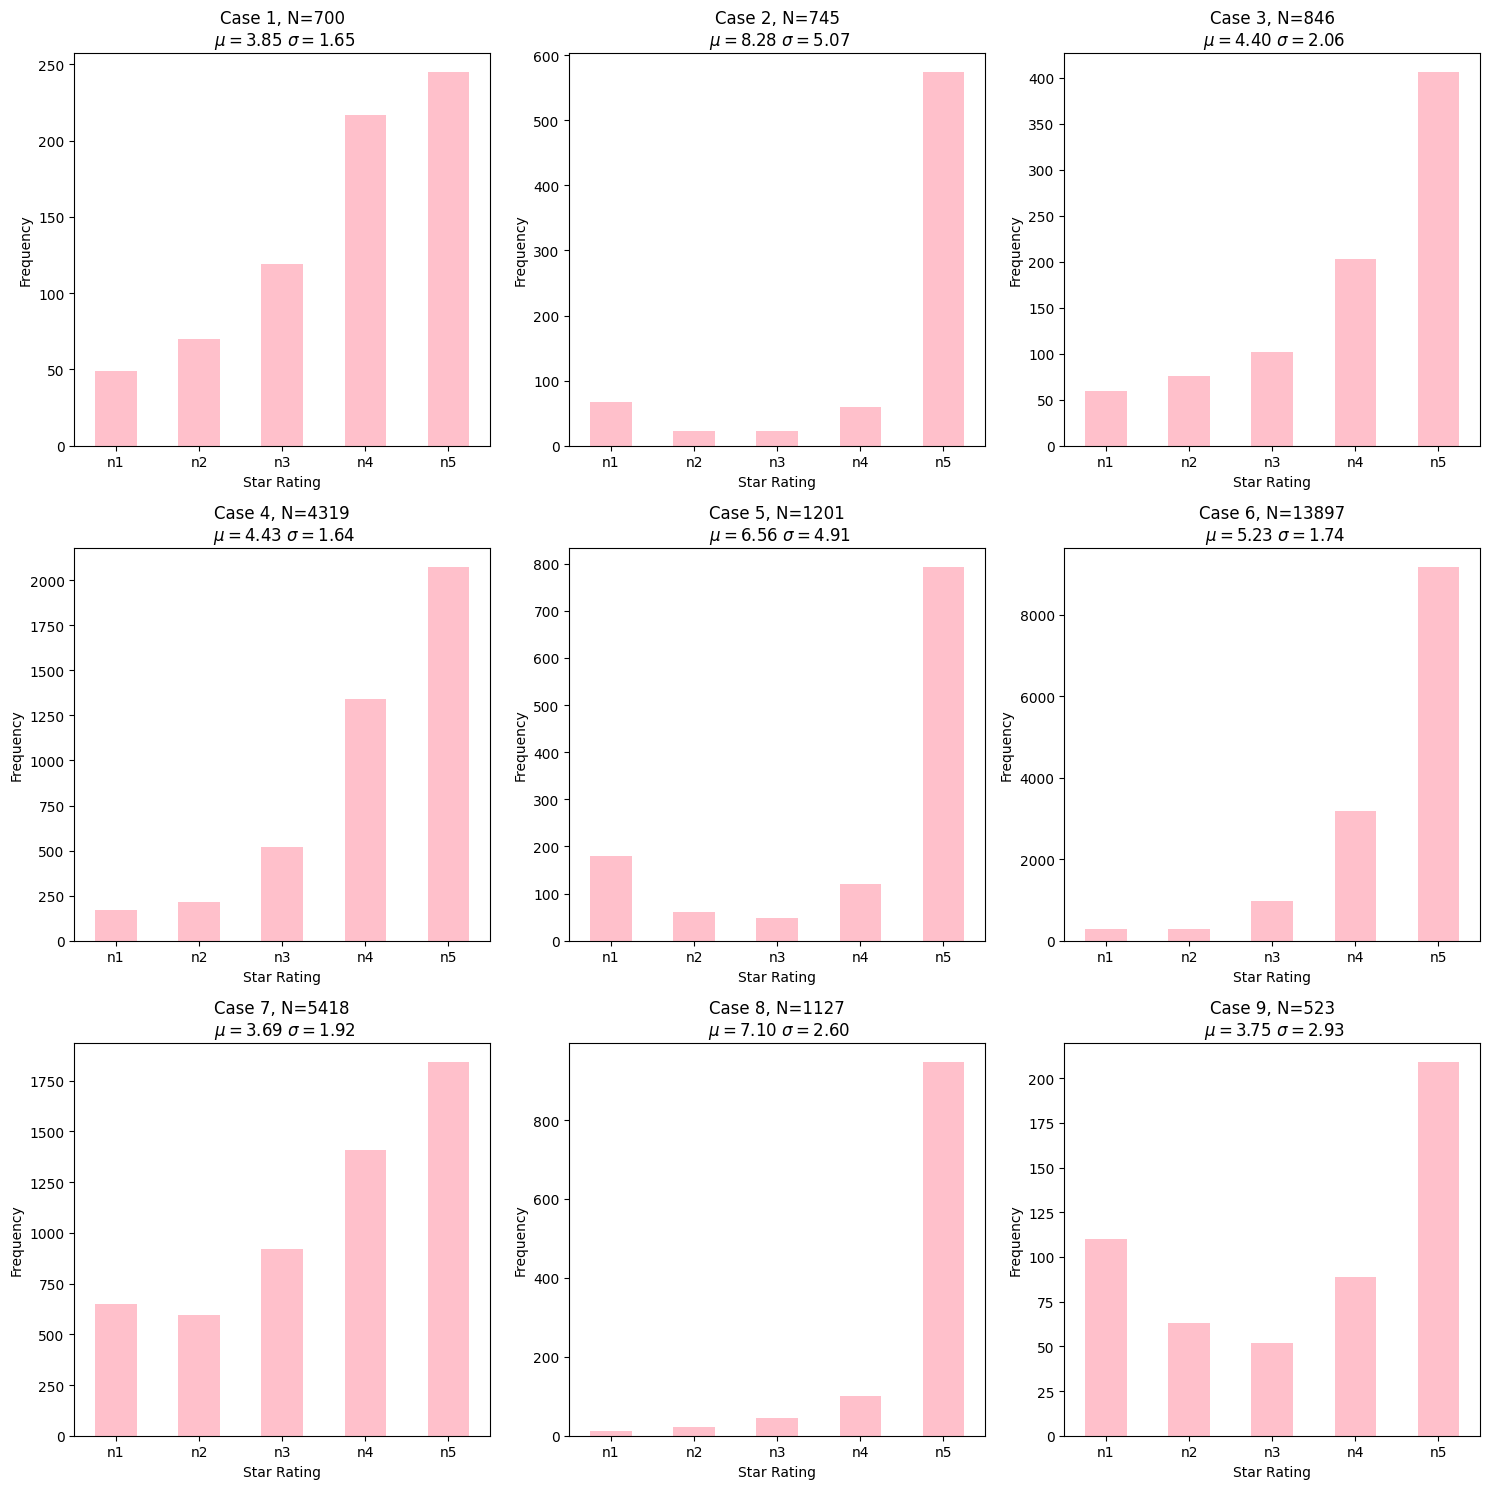

In [39]:
mu = trace['mu']
sigma = trace['sigma']

# Array with mu and sigma pairs (36x2)
trace_means = np.c_[mu.mean(axis=0), sigma.mean(axis=0)].reshape((Ncases,-1), order='F')

# Concatenate the fixed thresholds into the estimated thresholds (16000x4)
n = trace['theta_missing'].shape[0]
thresholds = np.c_[np.tile(thresh[0], (n,1)),
                   trace['theta_missing'],
                   np.tile(thresh[-1], (n,1))]

#def calc_posterior_pred_prob(mu, sigma, thresholds):
## Posterior predictive probabilities of the outcomes
#    threshCumProb = np.empty(thresholds.shape)
#    
#    for i in np.arange(threshCumProb.shape[0]):
#        threshCumProb[i] = norm().cdf((thresholds[i] - mu[i])/sigma[i])    
#    
#    outProb = (np.c_[threshCumProb, np.tile(1, (thresholds.shape[0],1))]
#               - np.c_[np.tile(0, (thresholds.shape[0],1)), threshCumProb])
#    
#    yerr = np.abs(np.subtract(pm.hpd(outProb), outProb.mean(axis=0).reshape(-1,1)))
#    
#    return(outProb, yerr)

fig, _axes = plt.subplots(3, 3, figsize=(15,15))
axes = _axes.flatten()

for i in np.arange(Ncases):
    data.iloc[i,2:].plot.bar(ax=axes[i], rot=0, color='pink')
    axes[i].set_xlabel('Star Rating')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title('Case {}, N={}\n $\mu={:.2f}$ $\sigma={:.2f}$'.format(data.ID[i],
                                                            z[i],
                                                            trace_means[i,0],
                                                            trace_means[i,1]))  
    
    #outProb, yerr = calc_posterior_pred_prob(mu[:,i], sigma[:,i], thresholds)
    #axes[i].errorbar(x = np.arange(nYlevels), y=outProb.mean(axis=0)*z[i],
    #         yerr=yerr.T*z[i], color=color, fmt='o')
    
plt.tight_layout()

#### Kruschke, J. K., & Liddell, T.

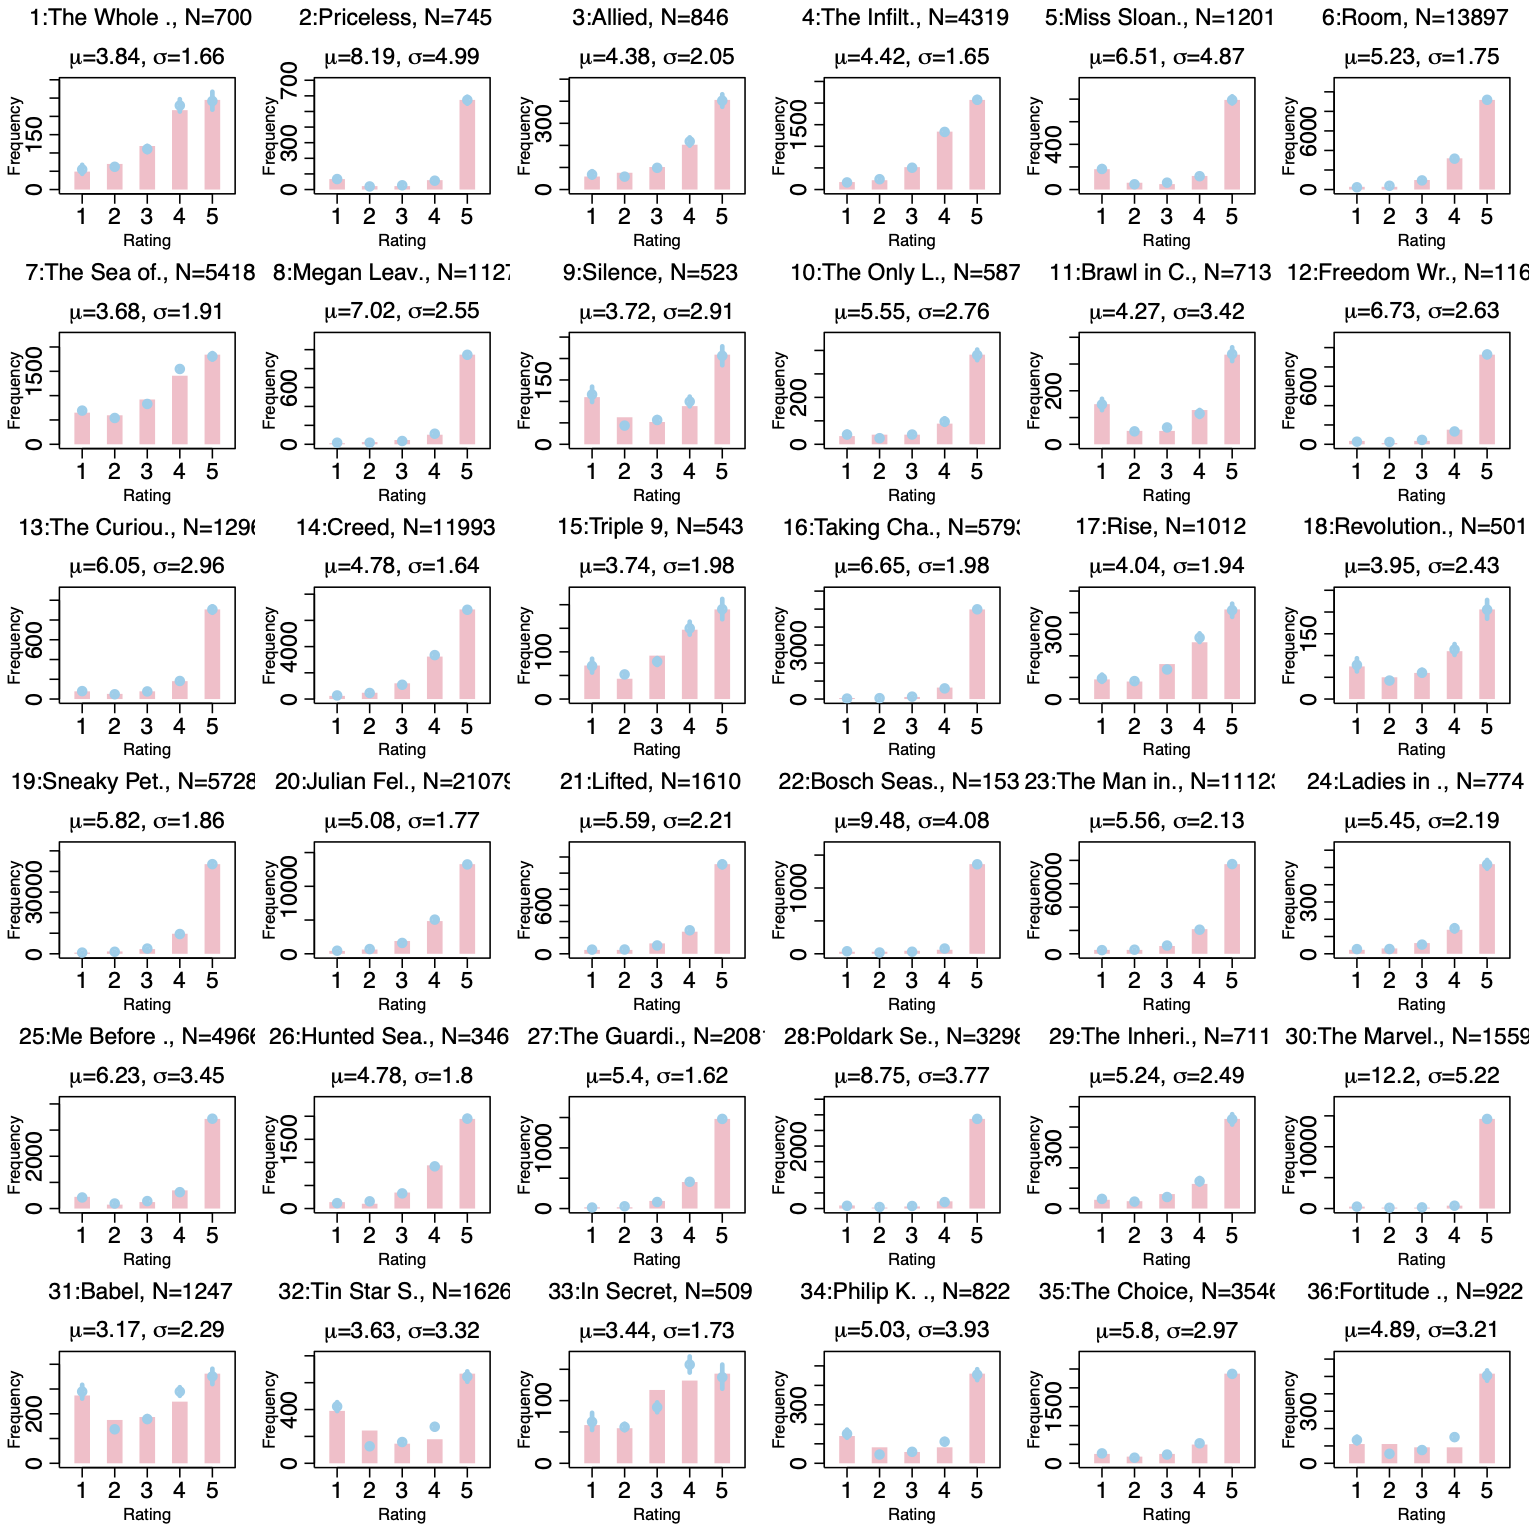

In [204]:
Image('images/OrderedProbitModel-MoviesData-OrdModel-PostPred.png', width=800)